## Homework 17: SVM
**Conditions**: 
- Dataset: Boston Housing
- Metric: RMSE


**Goal**: try SVM

**Acceptance criteria**:  get workable SVM models

# EDA

**Importing necessary libraries**

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.svm import SVR, LinearSVR
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics

**Loading dataset**

In [2]:
url = "https://raw.githubusercontent.com/selva86/datasets/master/BostonHousing.csv"
df = pd.read_csv(url)

# EDA

**First glance on the dataset**

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   crim     506 non-null    float64
 1   zn       506 non-null    float64
 2   indus    506 non-null    float64
 3   chas     506 non-null    int64  
 4   nox      506 non-null    float64
 5   rm       506 non-null    float64
 6   age      506 non-null    float64
 7   dis      506 non-null    float64
 8   rad      506 non-null    int64  
 9   tax      506 non-null    int64  
 10  ptratio  506 non-null    float64
 11  b        506 non-null    float64
 12  lstat    506 non-null    float64
 13  medv     506 non-null    float64
dtypes: float64(11), int64(3)
memory usage: 55.5 KB


In [4]:
df.describe()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


chas, rad seems to be categorical features

In [5]:
df['chas'].value_counts(normalize=True)

chas
0    0.93083
1    0.06917
Name: proportion, dtype: float64

Can remove CHAS because 93% of data is 0

In [6]:
df['rad'].value_counts(normalize=True)

rad
24    0.260870
5     0.227273
4     0.217391
3     0.075099
6     0.051383
2     0.047431
8     0.047431
1     0.039526
7     0.033597
Name: proportion, dtype: float64

In [7]:
df = df.drop('chas', axis=1)

**TARGET DISTRIBUTION INVESTIGATION**

/mnt/VOL/anaconda3/envs/teachme/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


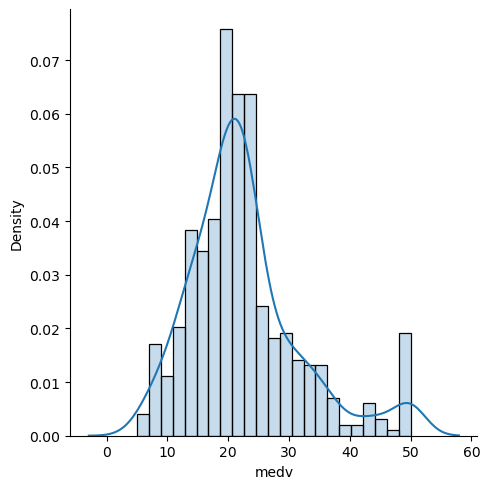

In [8]:
sns.displot(df['medv'], kde=True, stat='density', kde_kws=dict(cut=3), alpha=0.25)
plt.show()

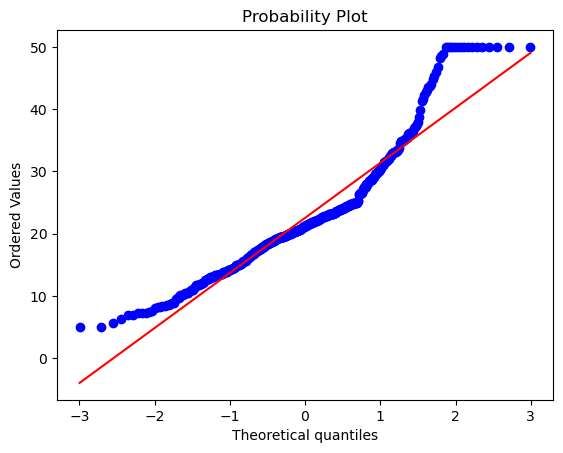

In [9]:
fig = plt.figure()
stats.probplot(df['medv'], plot=plt)
plt.show()

Not normal distribution
Will try to use logarithm to make it better.

/mnt/VOL/anaconda3/envs/teachme/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


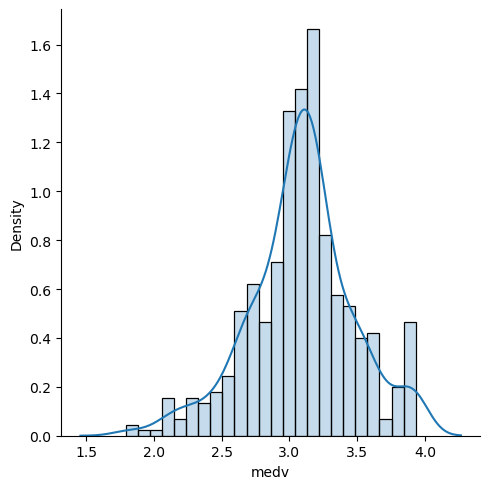

In [10]:
log_sales = np.log1p(df['medv'])
sns.displot(log_sales, kde=True, stat='density', kde_kws=dict(cut=3), alpha=0.25)
plt.show()

In [11]:
print(log_sales.describe())

count    506.000000
mean       3.085437
std        0.386966
min        1.791759
25%        2.891757
50%        3.100092
75%        3.258097
max        3.931826
Name: medv, dtype: float64


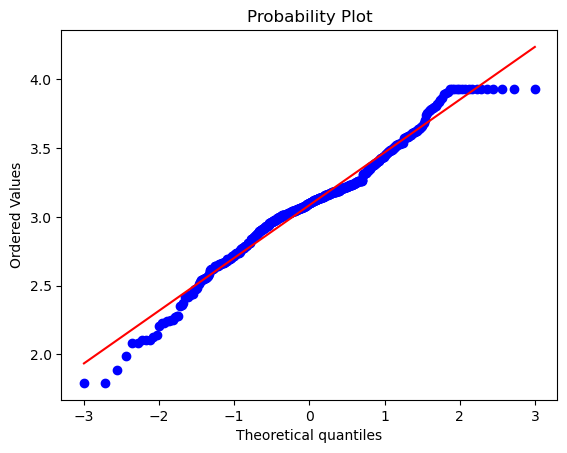

In [12]:
fig = plt.figure()
stats.probplot(log_sales, plot=plt)
plt.show()

Now distribution of target is better
Will use logarithm values in final dataset

In [13]:
df['medv'] = log_sales

**Correlation check**

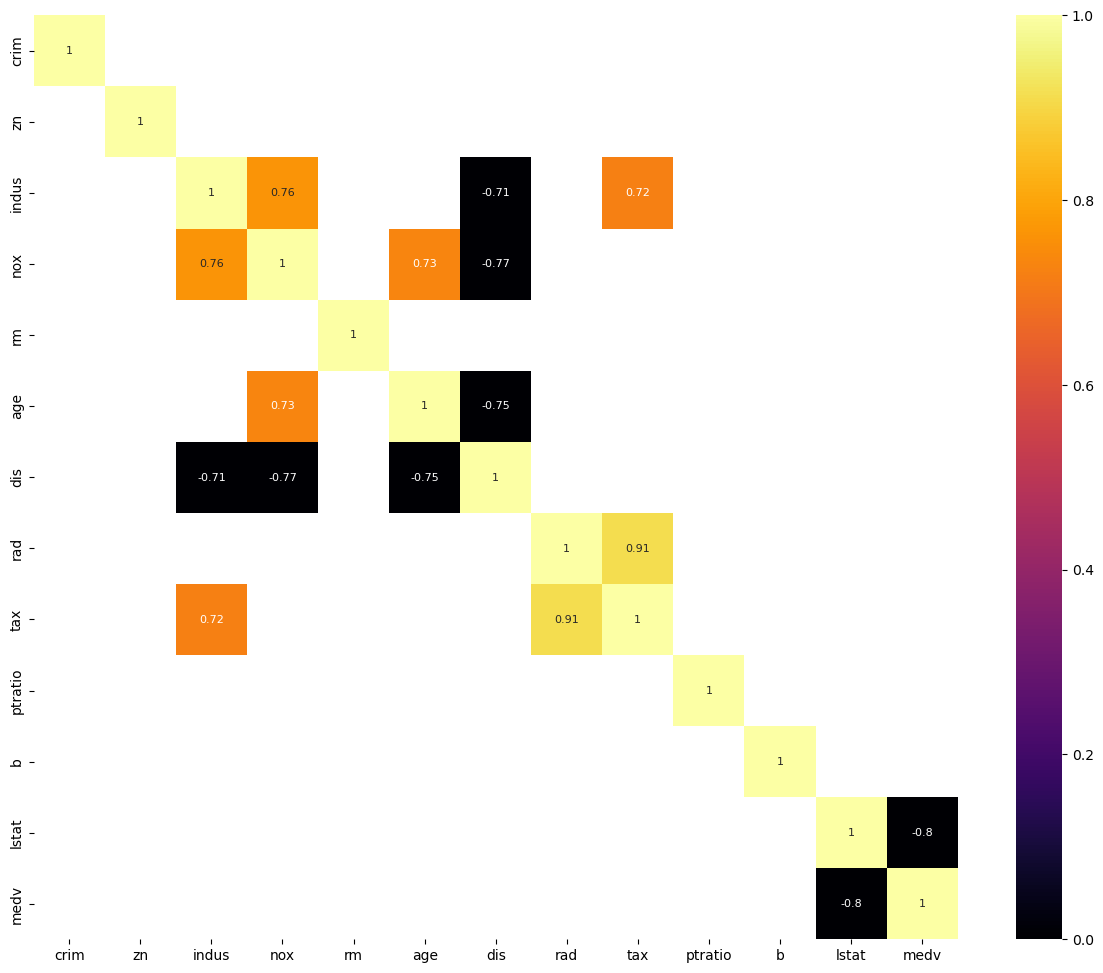

In [14]:
corr = df.corr()
plt.subplots(figsize=(15, 12))
sns.heatmap(
    corr[abs(corr) > 0.7],
    vmax=1.0, vmin=0.0,
    annot=True, annot_kws={'size': 8},
    square=True, cmap='inferno'
)
plt.show()

indus vs. nox = 0.76
The higher proportion of non-retail business acres per town, the higher nitric oxides concentration -> make sense
indus vs. dis = -0.71
The higher proportion of non-retail business acres per town, the lower weighted distances to five Boston employment centres -> seems reasonable
indus vs. tax = 0.72
The higher proportion of non-retail business acres per town, the higher full-value property-tax rate -> make sense

nox vs. age = 0.73
The higher nitric oxides concentration (parts per 10 million), the higher proportion of owner-occupied units built prior to 1940 -> no sense
nox vs. dis = -0.77
The higher nitric oxides concentration (parts per 10 million), the lower weighted distances to five Boston employment centres -> no sense

age vs. dis = -0.75
The higher proportion of owner-occupied units built prior to 1940, the lower weighted distances to five Boston employment centres -> make sense if employment centres were built in new areas.

rad vs. tax = 0.91
The higher index of accessibility to radial highways, the higher full-value property-tax rate per $10,000 -> make sense

**Conclusion: seems that indus, dis, rad can be removed**

CRIM - per capita crime rate by town
ZN - proportion of residential land zoned for lots over 25,000 sq.ft.
INDUS - proportion of non-retail business acres per town.
CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)
NOX - nitric oxides concentration (parts per 10 million)
RM - average number of rooms per dwelling
AGE - proportion of owner-occupied units built prior to 1940
DIS - weighted distances to five Boston employment centres
RAD - index of accessibility to radial highways
TAX - full-value property-tax rate per USD 10,000
PTRATIO - pupil-teacher ratio by town
B - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
LSTAT - % lower status of the population
MEDV - Median value of owner-occupied homes in USD 1000's

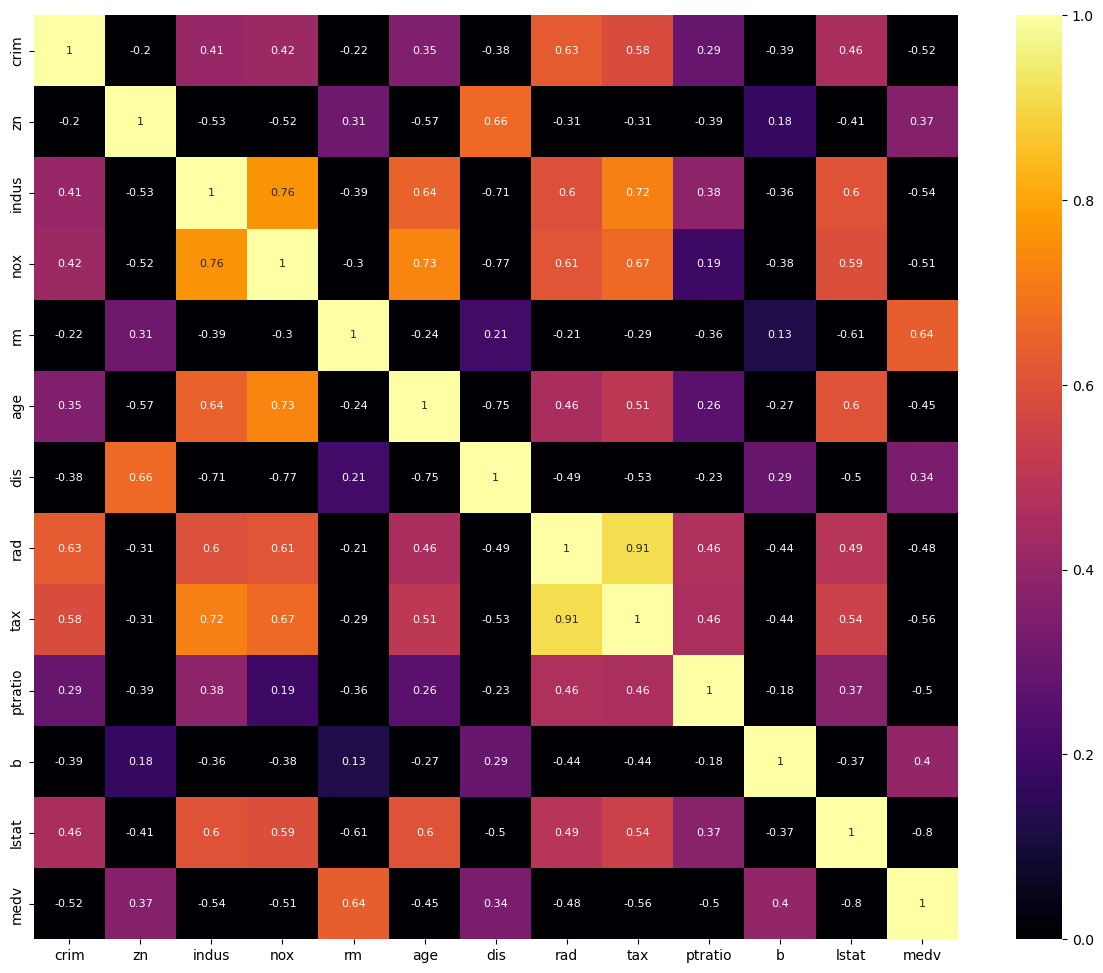

In [15]:
corr = df.corr()
plt.subplots(figsize=(15, 12))
sns.heatmap(
    corr,
    vmax=1.0, vmin=0.0,
    annot=True, annot_kws={'size': 8},
    square=True, cmap='inferno'
)
plt.show()

In [16]:
to_remove = ['indus', 'dis', 'rad']

In [17]:
df_analyze = df.drop(to_remove, axis=1)

In [18]:
df_analyze

,crim,zn,nox,rm,age,tax,ptratio,b,lstat,medv
0,0.00632,18.0,0.538,6.575,65.2,296,15.3,396.90,4.98,3.218876
1,0.02731,0.0,0.469,6.421,78.9,242,17.8,396.90,9.14,3.117950
2,0.02729,0.0,0.469,7.185,61.1,242,17.8,392.83,4.03,3.575151
3,0.03237,0.0,0.458,6.998,45.8,222,18.7,394.63,2.94,3.538057
4,0.06905,0.0,0.458,7.147,54.2,222,18.7,396.90,5.33,3.616309
...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,0.573,6.593,69.1,273,21.0,391.99,9.67,3.152736
502,0.04527,0.0,0.573,6.120,76.7,273,21.0,396.90,9.08,3.072693
503,0.06076,0.0,0.573,6.976,91.0,273,21.0,396.90,5.64,3.214868
504,0.10959,0.0,0.573,6.794,89.3,273,21.0,393.45,6.48,3.135494


# MODELS

Spliting the data and target into training/testing sets

In [19]:
X = df_analyze.drop('medv', axis=1)

y = df_analyze['medv']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Will use MinMaxScaler() to normalize both train and test sets

In [20]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Creating a ditionary to collect results

In [21]:
results = {'Regression': [], 'RMSE on test': [], 'RMSE on train': [], 'Difference': []}

In [22]:
def get_results(model):
    """
    Function to get RMSE results of a model.
    param model: any model from sklearn
    return: set -> RMSE for test and RMSE for train set
    """

    regr = model

    #Fit model
    regr.fit(X_train, y_train)

    #predict
    test_prediction = regr.predict(X_test)
    train_prediction = regr.predict(X_train)


    train_rmse = metrics.mean_squared_error(train_prediction, y_train, squared=False)
    test_rmse = metrics.mean_squared_error(test_prediction, y_test, squared=False)

    print(str(model))
    print("RMSE on train with {} is {}".format(str(model), train_rmse))
    print("RMSE on test with {} is {}".format(str(model), test_rmse))
    print()

    results['Regression'].append(str(model))
    results['RMSE on test'].append(test_rmse)
    results['RMSE on train'].append(train_rmse)
    results['Difference'].append(test_rmse - train_rmse)

# SVM

**SVR**

In [23]:
# tuning SVR
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
C_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
svr_results = []
for kernel in kernels:
    for C_value in C_values:
        svr = SVR(kernel=kernel, C=C_value)
        svr.fit(X_train, y_train)
        y_pred = svr.predict(X_test)
        print(f"RMSE using {kernel} kernel and C={C_value}: {metrics.mean_squared_error(y_test, y_pred, squared=False)}")
        svr_results.append([metrics.mean_squared_error(y_test, y_pred, squared=False), kernel, C_value])
        

RMSE using linear kernel and C=0.001: 0.34353616140550014
RMSE using linear kernel and C=0.01: 0.243930432454644
RMSE using linear kernel and C=0.1: 0.19957366557006653
RMSE using linear kernel and C=1: 0.203970560788159
RMSE using linear kernel and C=10: 0.20684631838928494
RMSE using linear kernel and C=100: 0.20686106840834226
RMSE using linear kernel and C=1000: 0.20688285348174756
RMSE using poly kernel and C=0.001: 0.22704329241641288
RMSE using poly kernel and C=0.01: 0.18071024130236488
RMSE using poly kernel and C=0.1: 0.15794003747977925
RMSE using poly kernel and C=1: 0.15784482822690113
RMSE using poly kernel and C=10: 0.1848833542474263
RMSE using poly kernel and C=100: 0.2011101563672613
RMSE using poly kernel and C=1000: 0.25386496391514735
RMSE using rbf kernel and C=0.001: 0.35669687343694656
RMSE using rbf kernel and C=0.01: 0.2695688110272276
RMSE using rbf kernel and C=0.1: 0.19031765762951983
RMSE using rbf kernel and C=1: 0.16189911296607112
RMSE using rbf kernel 

In [24]:
min_rmse = svr_results[0]
for i in range(1, len(svr_results)):
    if svr_results[i][0] < min_rmse[0]:
        min_rmse = svr_results[i]
print(min_rmse)

[0.15784482822690113, 'poly', 1]


In [25]:
#using best params to train the model
get_results(SVR(kernel='poly', C=1))

SVR(C=1, kernel='poly')
RMSE on train with SVR(C=1, kernel='poly') is 0.1296171596773357
RMSE on test with SVR(C=1, kernel='poly') is 0.15784482822690113



**LinearSVR**

In [26]:
# tuning LinearSVR
# 'epsilon-insensitive' = L1 loss
# ‘squared_epsilon_insensitive’ = L2 loss.
losses = ['epsilon_insensitive', 'squared_epsilon_insensitive']
C_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
linear_svr_results = []
for loss in losses:
    for C_value in C_values:
        linear_svr = LinearSVR(loss=loss, C=C_value)
        linear_svr.fit(X_train, y_train)
        y_pred = linear_svr.predict(X_test)
        print(f"RMSE using {loss} loss and C={C_value}: {metrics.mean_squared_error(y_test, y_pred, squared=False)}")
        linear_svr_results.append([metrics.mean_squared_error(y_test, y_pred, squared=False), loss, C_value])


RMSE using epsilon_insensitive loss and C=0.001: 1.9273708290453777
RMSE using epsilon_insensitive loss and C=0.01: 0.36607364404379117
RMSE using epsilon_insensitive loss and C=0.1: 0.23573915438066603
RMSE using epsilon_insensitive loss and C=1: 0.2102289056816983
RMSE using epsilon_insensitive loss and C=10: 0.2054913701913498
RMSE using epsilon_insensitive loss and C=100: 0.21590342483037667


/mnt/VOL/anaconda3/envs/teachme/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/mnt/VOL/anaconda3/envs/teachme/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/mnt/VOL/anaconda3/envs/teachme/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/mnt/VOL/anaconda3/envs/teachme/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  war

RMSE using epsilon_insensitive loss and C=1000: 0.2566698471584852
RMSE using squared_epsilon_insensitive loss and C=0.001: 1.0304793688531433
RMSE using squared_epsilon_insensitive loss and C=0.01: 0.3944020542477809
RMSE using squared_epsilon_insensitive loss and C=0.1: 0.2519458275114272
RMSE using squared_epsilon_insensitive loss and C=1: 0.20484937965560715
RMSE using squared_epsilon_insensitive loss and C=10: 0.2018921913571281
RMSE using squared_epsilon_insensitive loss and C=100: 0.219934995037058
RMSE using squared_epsilon_insensitive loss and C=1000: 0.20850969084339288


/mnt/VOL/anaconda3/envs/teachme/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/mnt/VOL/anaconda3/envs/teachme/lib/python3.10/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/mnt/VOL/anaconda3/envs/teachme/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/mnt/VOL/anaconda3/envs/teachme/lib/python3.10/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [27]:
min_rmse_linearsvr = linear_svr_results[0]
for i in range(1, len(linear_svr_results)):
    if linear_svr_results[i][0] < min_rmse_linearsvr[0]:
        min_rmse_linearsvr = linear_svr_results[i]
print(min_rmse_linearsvr)

[0.2018921913571281, 'squared_epsilon_insensitive', 10]


In [28]:
#using best params to train the model
get_results(LinearSVR(loss='squared_epsilon_insensitive', C=10))

LinearSVR(C=10, loss='squared_epsilon_insensitive')
RMSE on train with LinearSVR(C=10, loss='squared_epsilon_insensitive') is 0.18918677918019353
RMSE on test with LinearSVR(C=10, loss='squared_epsilon_insensitive') is 0.20189684510514438



/mnt/VOL/anaconda3/envs/teachme/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


In [29]:
results_df = pd.DataFrame(results)
results_df 

,Regression,RMSE on test,RMSE on train,Difference
0,"SVR(C=1, kernel='poly')",0.157845,0.129617,0.028228
1,"LinearSVR(C=10, loss='squared_epsilon_insensit...",0.201897,0.189187,0.012710


SVR showed better results on this dataset